# HW_2_Javier_Gilabert_Sabater
## Análisis Predictivo

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read Data
df = pd.read_csv('StackOverflow.csv')
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


## 1. - Analizar los datos de MATLAB, entre otros análisis, se debe graficar la serie, estudiar la estacionalidad y la estacionariedad.

In [4]:
df_matlab  = pd.DataFrame()
df_matlab['month'] = df['month']
df_matlab['matlab'] = df['matlab']
df_matlab

,month,matlab
0,09-Jan,19
1,09-Feb,27
2,09-Mar,24
3,09-Apr,32
4,09-May,42
...,...,...
127,19-Aug,371
128,19-Sep,362
129,19-Oct,523
130,19-Nov,479


In [5]:
df_matlab['month'] = pd.to_datetime(df_matlab['month'], format='%y-%b')
df_matlab = df_matlab.set_index('month')
df_matlab

,matlab
month,
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42
...,...
2019-08-01,371
2019-09-01,362
2019-10-01,523


<Axes: xlabel='month'>

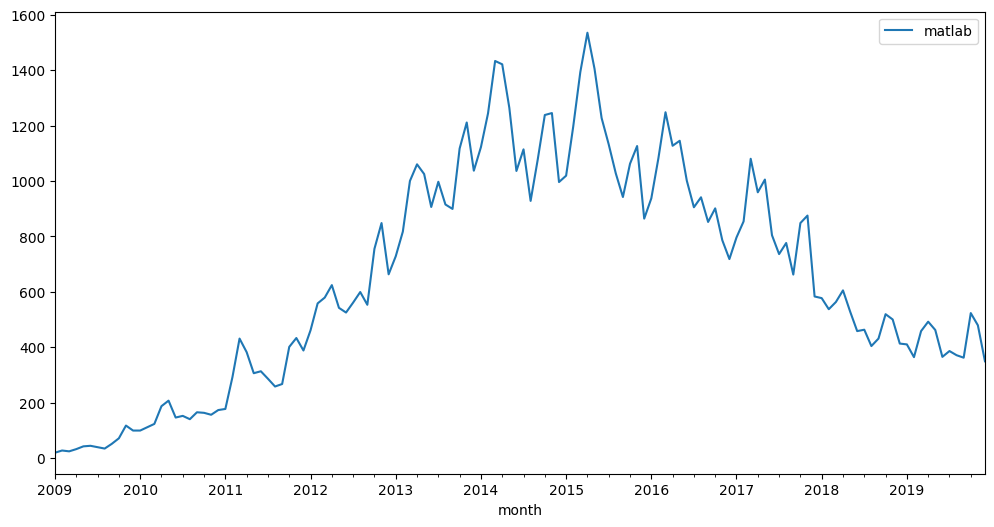

In [6]:
plt.rcParams["figure.figsize"] = (12,6)
df_matlab.plot()

## Estacionalidad

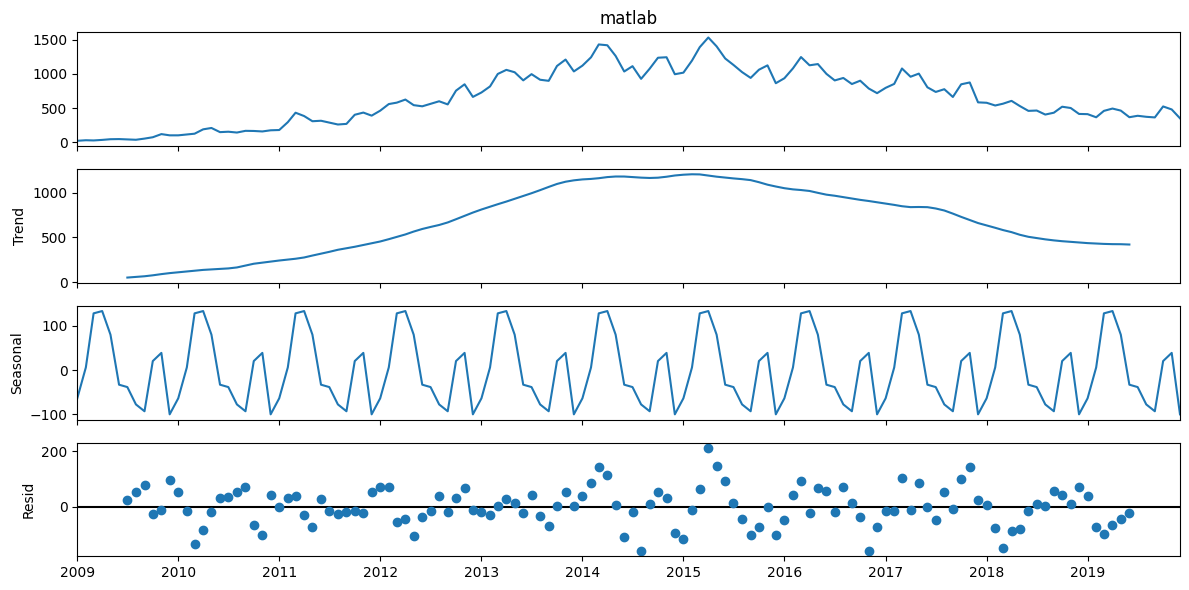

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_matlab['matlab'], model='additive', period=12)
result.plot()
plt.show()


Text(0.5, 1.0, 'Comportamiento Estacional')

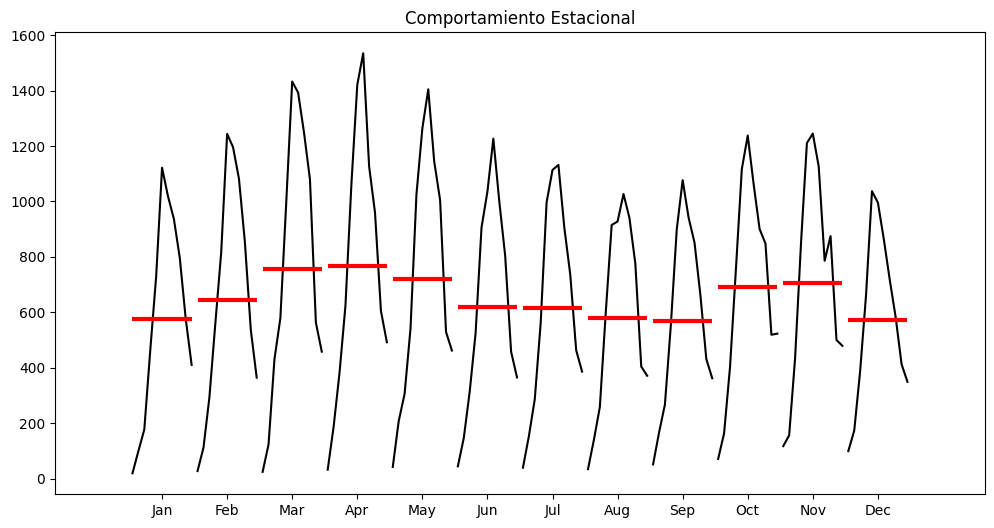

In [8]:
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.month_plot(df_matlab['matlab'],ax=ax)
ax.set_title('Comportamiento Estacional')

## Estacionariedad

In [13]:
# Log Transformer Function
from sktime.transformations.series.boxcox import LogTransformer

In [15]:
# Apply Log Transformer

transformer = LogTransformer()
log_matlab= transformer.fit_transform(df_matlab)
log_matlab.tail()

,matlab
month,
2019-08-01,5.916202
2019-09-01,5.891644
2019-10-01,6.259581
2019-11-01,6.171701
2019-12-01,5.855072


Text(0.5, 1.0, 'Ventas Coca Cola: Transformación LOG')

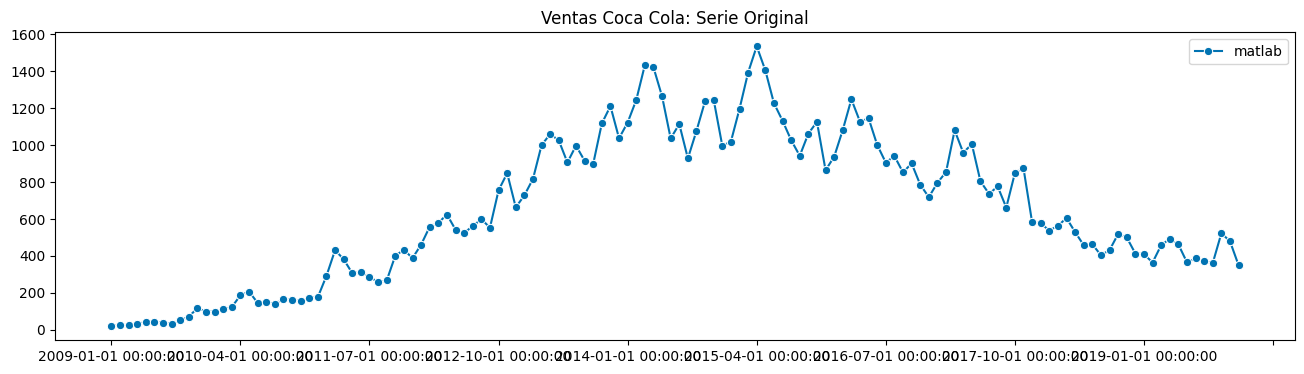

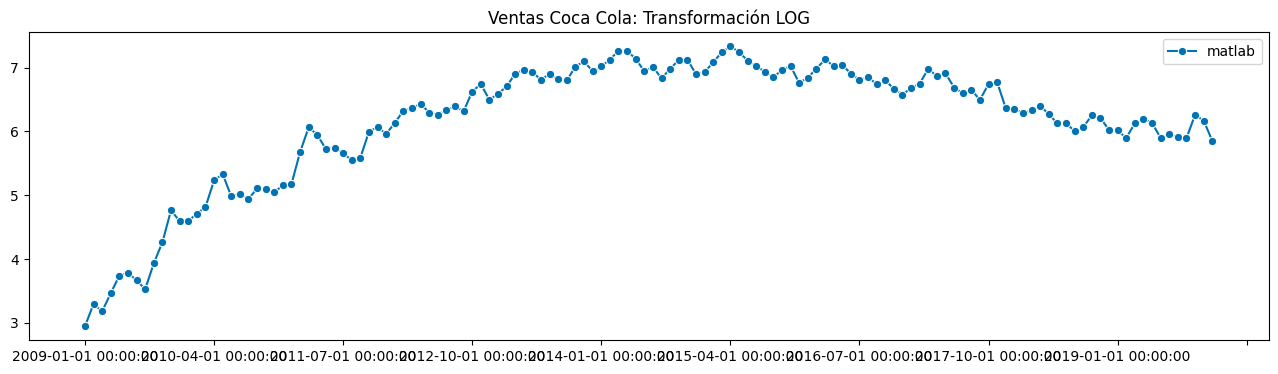

In [20]:
# Plot Log Data
#ax = log_matlab.plot(marker='o', linestyle='-')
#ax.set_ylabel('Preguntas sobre matlab')
#ax.set_title('Preguntas sobre matlab: Transformación LOG')
from sktime.utils.plotting import plot_series
fig, ax =plot_series(df_matlab, labels=["matlab"])
ax.set_title('Ventas Coca Cola: Serie Original')
fig, ax =plot_series(log_matlab, labels=["matlab"])
ax.set_title('Ventas Coca Cola: Transformación LOG')

## 2. - Se debe separa la muestra en tres partes entrenamiento, validación(12 meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.

In [21]:
df_matlab

,matlab
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42
...,...
2019-08-01,371
2019-09-01,362
2019-10-01,523
2019-11-01,479


In [25]:

data_train = df_matlab['2009-01-01':'2019-01-01']
data_valid = df_matlab['2019-01-01':'2019-12-01']
data_test = df_matlab['2019-06-01':'2019-12-01']


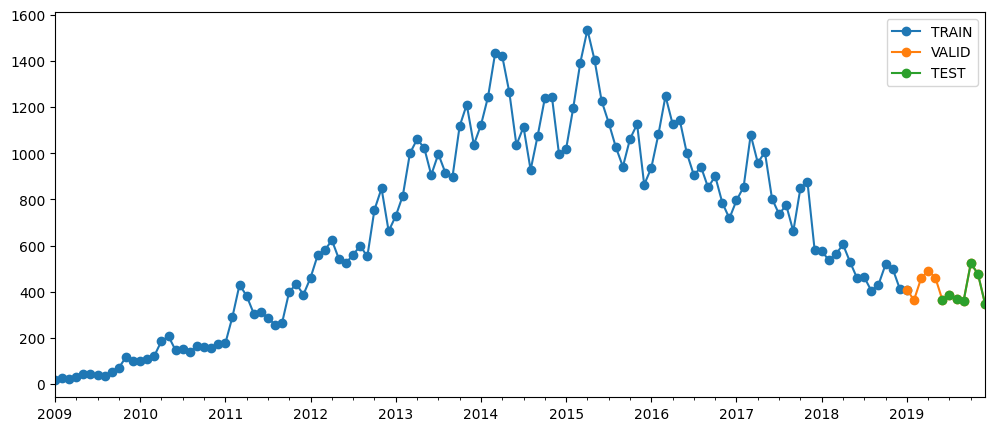

In [35]:
data_train['matlab'].plot(legend=True,label='TRAIN',marker='o')
data_valid['matlab'].plot(legend=True,label='VALID',figsize=(12,5),marker='o');
data_test['matlab'].plot(legend=True,label='TEST',figsize=(12,5),marker='o');